# Cooperative Prey Herding Based On Diffusion Adaption

This notebook shows how to simulate the perying process of multiple fishes with BlueFog library. It is recommended to read the [single-fish demo](./SingleFishHuntForFood.ipynb) first.

### Basic Setup

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
import matplotlib.pyplot as plt

**Attention**! The following command facilitates animation figures.

In [3]:
%matplotlib notebook   

After running the following cell, you will see {np} (where `np` is the number of processes you created with command `ibfrun start -np XX`) outputs and each output should have different rank number.

In [4]:
rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 1 among 8 processes
[stdout:1] Hello, I am 3 among 8 processes
[stdout:2] Hello, I am 5 among 8 processes
[stdout:3] Hello, I am 4 among 8 processes
[stdout:4] Hello, I am 6 among 8 processes
[stdout:5] Hello, I am 7 among 8 processes
[stdout:6] Hello, I am 0 among 8 processes
[stdout:7] Hello, I am 2 among 8 processes


In [6]:
dview = rc[:] # A DirectView of all engines
dview.block=True

## 1. Multiple fishes move towards the food source

In this section, we will simulate the scenario where a bunch of fishes will move to the food source. Compared to the signel fish scenario, there are several major differences:

- the fishes will communiate and exchange information with neighbors to better estimate the food source

- the fishes will move in synchrony to confuse predators but would also like to avoid collisions by maintaining a safe distance from their neighbors

### 1.1 Find neighbors

The fish schools communicate in a decentralized manner. Each fish will communicate (or exchange information) with its direct neighbors. If the distance between fish $i$ and $j$ are within a predefined distance $r_1$, i.e., $\mathrm{dist}(i,j) < r_1$, we regard them as direct neighbors. Moreover, since each fish keeps changing its position during the procss of hunting for food, they will find new direct neighbors per update.

There are two different ways to let each fish find its direct neighbors:

In the **first** approach, we let each fish run `allgather` operation to collect the location of *all* other fishes, and then find neighbors that are within its $r_1$ distance. While this method involves a global operation `allgather` and is hence not decentralized, it is reasonable to do it in simulations. In real practical scenario such as robot networks, each robot can find its neighbors with sensors without centralized coordination and hence the allgather operation will not be necessary any more.

In [7]:
%%px

def find_neighbors_allgather(x, r1):
    
    # pre-process
    x = x.reshape(-1,1)
    
    # construct a three-dim tensor [loc_x, loc_y, rank]
    location = torch.zeros(3)
    location[0], location[1], location[2] = x[0], x[1], bf.rank()
    
    # get the position of all other fishes through allgather
    global_location_list = bf.allgather(location, 'location')
    
    # construct the list of direct neighbors
    neighbors = []
    for i in range(2, len(global_location_list), 3):
        
        if int(global_location_list[i]) == bf.rank():
            continue
            
        # calculate dist; find neighbors with dist < r1
        x_nb = global_location_list[i-2:i].reshape(-1,1)
        dist = torch.norm(x - x_nb)
        if dist < r1:
            neighbors.append(int(global_location_list[i]))
            
    # construct self_weight and neighbor_weights for future use
    self_weight = 1./(len(neighbors)+1)
    neighbor_weights = {}
    for nb in neighbors:
        neighbor_weights[nb] = 1./(len(neighbors)+1)
    
    return self_weight, neighbor_weights

After runing the following code, you can find self_weight, the neighbors' indexes and weights of each fish.

In [9]:
%%px

self_weight, neighbor_weights = find_neighbors_allgather(x = torch.ones(2,1)*bf.rank(), r1 = 3)
print('Fish {} has self_weight {} and neighbor_weights {}'.format(bf.rank(), self_weight, neighbor_weights))

[stdout:0] Fish 1 has self_weight 0.25 and neighbor_weights {0: 0.25, 2: 0.25, 3: 0.25}
[stdout:1] Fish 3 has self_weight 0.2 and neighbor_weights {1: 0.2, 2: 0.2, 4: 0.2, 5: 0.2}
[stdout:2] Fish 5 has self_weight 0.2 and neighbor_weights {3: 0.2, 4: 0.2, 6: 0.2, 7: 0.2}
[stdout:3] Fish 4 has self_weight 0.2 and neighbor_weights {2: 0.2, 3: 0.2, 5: 0.2, 6: 0.2}
[stdout:4] Fish 6 has self_weight 0.25 and neighbor_weights {4: 0.25, 5: 0.25, 7: 0.25}
[stdout:5] Fish 7 has self_weight 0.3333333333333333 and neighbor_weights {5: 0.3333333333333333, 6: 0.3333333333333333}
[stdout:6] Fish 0 has self_weight 0.3333333333333333 and neighbor_weights {1: 0.3333333333333333, 2: 0.3333333333333333}
[stdout:7] Fish 2 has self_weight 0.2 and neighbor_weights {0: 0.2, 1: 0.2, 3: 0.2, 4: 0.2}


The **second** approach is to use `neighbor_allgather`. After each `neighbor_allgather` operation, each fish will get the position of its one-hop neighbors. We let each fish run two rounds of `neighbor_allgather` operations and hence it will hold the posiitons of its both one-hop and two-hop neighbors. After checking the distance to these neighbors, we can find its new direct neighbors within distance $r_1$. Compared to the above `allgather` strategy, this method only involves decentralized oprations. However, this method does not check all fishes in the school. It is possible that some fish not belonging to its previous one-hop and two-hop neighbors can become its direct neighbors at this update. The `neighbor_allgather` stragety unfortunately will miss this case.

In [10]:
%%px

def find_neighbors_neighbor_allgather(x, r1):
    
    return 

### 1.2 Cooperative target estimation via diffusion algorithm

Each fish in the school will observe its local distance and direction to the target $w^o$. It is proved in literature that a better estimation of the target position can be achieved if all fishes cooperate by exachging information with neighbors. One of the cooperative algorithm is diffusion, see [[2]](https://asl.epfl.ch/wp-content/uploads/publications/journal_articles/tsp_mar_2010a.pdf) and [[3]](https://ieeexplore.ieee.org/document/6197748/).

The diffusion algorithm to solve the cooperative estimation is as follows. Assume $a_{ij}$ is the weight to scale informaiton flowing form fish $j$ to fish $i$. At the $(k+1)$-th iteration, the algorithm recursion is: 

\begin{equation*}
\begin{split}
\phi_i^{k+1} &= w_i^k + \gamma u_i^k \big( d_i^k - (u_i^k)^T(w_i^k - x_i^k)\big) \\
w_i^{k+1} &= \sum_{j\in \mathcal{N}_i} a_{ij} \phi_j^{k+1}
\end{split}
\end{equation*}

where $d_i^k$ and $u_i^k$ are the local measurements of fish $i$, and $x_i^k$ is the current position of fish $i$ at iteration $k$. $\mathcal{N}_i$ is the set of neighboring fishes of fish $i$.

In [11]:
%%px

def diffusion_one_recursion(x, u, d, w, gamma, self_weight, neighbor_weights):
    
    # estimate target position
    d_estimate = u.T@(w - x)
    phi = w + gamma * u * (d - d_estimate[0,0])
    send_neighbors = list(neighbor_weights.keys())
    w = bf.neighbor_allreduce(phi, self_weight=self_weight, 
                              neighbor_weights=neighbor_weights,
                              send_neighbors=send_neighbors, 
                              enable_topo_check=True, name='phi')
    
    return w

### 1.3 Velocity

In a fish school, each single fish will move in synchrony but would also like to avoid collisions by maintaining a safe distance from their neighbors. Therefore, its velocity consists of three components:

- its local velocity calculated based on its current position and the estimated target position

- the averaged velocity of the fish school

- the velocity to avoid collisions with neighbors

#### 1.3.1 Local velocity

The local velocity can be calculated exactly the same as the above single fish sections. 

In [13]:
%%px

# local velocity
def local_velocity(target_position, current_position):
    
    target_position = target_position.reshape(-1,1)
    current_position = current_position.reshape(-1,1)
    
    return (target_position - current_position)/torch.norm(target_position - current_position)

#### 1.3.2 The group's averaged velocity

The averaged velocity of the fish school can be estimated via diffusion algorithm:
    
\begin{equation*}
\begin{split}
\psi_{g,i}^{k+1} &= (1-\beta) v_{g,i}^{k} + \beta v_{l,i}^{k+1} \\
v_{g,i}^{k+1} &= \sum_{j\in \mathcal{N}_i} a_{ij} \psi_{g,j}^{k+1}
\end{split}
\end{equation*}

where $v^k_{l,i}$ is the local velociy of fish $i$ at iteration $k$, and $\beta \in (0,1)$ is a constant.

In [15]:
%%px

# group velocity
def group_velocity(local_v, group_v, self_weight, neighbor_weights, beta):
    
    local_v = local_v.reshape(-1,1)
    group_v = group_v.reshape(-1,1)
    
    psi = (1-beta) * group_v + beta * local_v
    send_neighbors = list(neighbor_weights.keys())
    group_v = bf.neighbor_allreduce(psi, self_weight, neighbor_weights, 
                                    send_neighbors=send_neighbors,
                                    enable_topo_check=True, name='psi')
    
    return group_v

#### 1.3.3 Velocity to avoid collision

The velocity to avoid collision can be calculated as

$$ v^{k}_{c,i} = \frac{1}{|\mathcal{N}_i|-1}\sum_{j\in \mathcal{N}_i/{i}}(\|x_j^k - x_i^k\| - r_2) (\frac{x_j^k - x_i^k}{\|x_j^k - x_i^k\|})$$

where $r_2$ is the safe distance that the fishes want to keep. Appatently, if some fish $j$ is too close to fish $i$, i.e., $\|x_j^k - x_i^k\| < r_2$, the above expression will guarantee $v^k_{c,i}$ to drive fish $i$ moves away from $j$.

In [16]:
%%px

# group velocity
def avoid_collision_velocity(x, r1, r2):
    
    x = x.reshape(-1,1)
    
    # construct a three-dim tensor [loc_x, loc_y, rank]
    location = torch.zeros(3)
    location[0], location[1], location[2] = x[0], x[1], bf.rank()
        
    # get the position of all other fishes through allgather
    global_location_list = bf.allgather(location, 'location')
    
    # construct the list of direct neighbors
    vc = 0
    num_nbs = 0
    for i in range(2, len(global_location_list), 3):
        
        if int(global_location_list[i]) == bf.rank():
            continue
            
        # calculate dist; find neighbors with dist < r1
        x_nb = global_location_list[i-2:i].reshape(-1,1)
        dist = torch.norm(x - x_nb)
        if dist < r1:
            
            # is neighbor
            vc += (dist - r2) * (x_nb - x) /dist
            num_nbs += 1
    
    return vc/num_nbs

#### 1.3.4 Velocity to avoid collision

The final velocity of fish $i$ is given by

$$v_i^k = \lambda v_{l,i}^k + (1-\lambda) (v_{g,i}^k + v_{c,i}^k)$$

where $\lambda\in(0,1)$ is a constant to balance various velocities. 

### 1.4 Simulation starts

In [17]:
# Push the seed to all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

In [18]:
%%px
print("I received seed as value: ", seed)

_ = torch.random.manual_seed(seed * bf.rank())  # make sure different rank has different seed

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


In [19]:
%%px

# get u
def getU(target_position, current_position, noise = 0.1):
    return (target_position-current_position)/torch.norm(target_position-current_position) + torch.rand(2,1)*noise

# get d
def getD(u, target_position, current_position, noise = 0.1):
    d = u.T @ (target_position - current_position) 
    return d[0,0] + torch.rand(1)*noise

In [22]:
%%px

delta_t = 3      # time interval
fig_frames = 100 # figures frames
tail_length = 3  # the length of tail
gamma = 0.5      # for estimation
beta  = 0.5      # for group velocity
r1    = 20        # to determin neighbors
r2    = 10      # to keep save distance
lmd   = 0.5      # to balance velocities

# target
w_target = torch.tensor([100,100]).reshape(-1,1)

# position
X = torch.zeros((2,fig_frames))
x_init = torch.rand(2,1) * 3
w_init = torch.rand(2,1)

# start simulation
v_record = torch.zeros((2, fig_frames))
x_record = torch.zeros((2, fig_frames))
x = x_init.clone()
w = w_init.clone()
vg = torch.rand(2,1)

In [25]:
%%px

# one-step of the simulation
def multiple_fish_prey_one_step(ith):

    global w_target, x, w, v_record, x_record, vl, vg, beta

    # get measurements u and d
    u = getU(target_position=w_target, current_position=x, noise=0.5).reshape(-1,1)
    d = getD(u=u, target_position=w_target, current_position=x, noise=0.5)
    
    # find neighbors
    self_weight, neighbor_weights = find_neighbors_allgather(x, r1)
    
    # setup topology
    
    # estimate target position via diffusion
    w = diffusion_one_recursion(x, u, d, w, gamma, self_weight, neighbor_weights)
    
    # get local velocity
    vl = local_velocity(target_position = w, current_position = x)
    # get group velocity
    vg = group_velocity(vl, vg, self_weight, neighbor_weights, beta)
    # get collistion velocity
    vc = avoid_collision_velocity(x, r1, r2)
    # get final velocity
    v  = lmd * vl + (1-lmd) * (vg + vc)
    v  = v / torch.norm(v)
    
    # update current location
    x = x + delta_t*v
    
    # record data
    v_record[:, [i]] = v
    x_record[:,[i]] = x

In [26]:
# simulation starts
fig_frames = dview.pull('fig_frames', block=True, targets=0)
for i in range(0, fig_frames):
    
    if i % 10 == 0:
        print('progress: {}/{}'.format(i, fig_frames))
        
    dview.push({"ith": i}, block=True)
    %px multiple_fish_prey_one_step(ith)

progress: 0/100
progress: 10/100
progress: 20/100
progress: 30/100
progress: 40/100
progress: 50/100
progress: 60/100
progress: 70/100
progress: 80/100
progress: 90/100


<IPython.core.display.Javascript object>


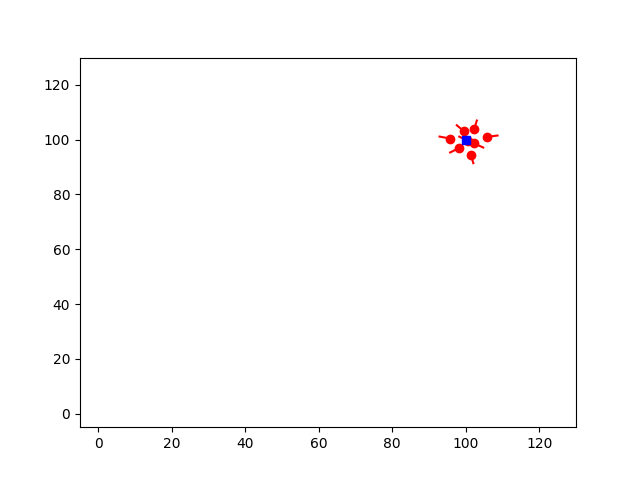

In [27]:
# plot figures
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

world_size = dview.pull('bf.size()', block=True, targets=0)
fig_frames = dview.pull('fig_frames', block=True, targets=0)
tail_length = dview.pull('tail_length', block=True, targets=0)
w_target = dview.pull('w_target', block=True, targets=0)

for i in range(0,fig_frames):
    ax.clear()
    
    X_current_across_network = np.zeros((2, world_size))
    V_current_across_network = np.zeros((2, world_size))
    
    for k in range(world_size):
        X_current_across_network[:,[k]] = dview.pull('x_record[:, [{}]]'.format(i), block=True, targets=k)
        V_current_across_network[:,[k]] = dview.pull('v_record[:, [{}]]'.format(i), block=True, targets=k)
    
    ax.plot(X_current_across_network[0,:], X_current_across_network[1,:], 'ro')

    for k in range(world_size):
        vx, vy = V_current_across_network[0,k], V_current_across_network[1,k]
        x, y = X_current_across_network[0,k], X_current_across_network[1,k]
        ax.plot([x-tail_length*vx,x], [y-tail_length*vy, y], 'r-')

    ax.plot(w_target[0], w_target[1], 'bs')
    ax.axis([-5, 130, -5, 130])
    fig.canvas.draw()
    plt.pause(0.1)

You can adjust the value of $r_1$, $r_2$, and $\lambda$ to examine their influences on the fish schools.

## 2. Multiple fishes move across a static predator

In this section, we will simulate the scenario where a bunch of fishes will across a static predator while moving to the food source. Compared to the multiple fishes scenario without a predator, there is only one major difference:

- correct the velocity so that each fish can go around the static predator when it gets close

#### 2.1 Velocity to avoid the static predator

Fishes located in different areas will respond differently to the predator. See the picture below:

<img src="./static_predator1.png" alt="ibfrun" width="480"/>

We first define two velocities: $v_e$ is the velocity to escape from the predator, and $v_f$ is the velocity to move toward the food target:

$$v_e =  \frac{x - w_d}{\|x - w_d\|}, \quad \quad v_f = \frac{w_f - x}{\|w_f - x\|}$$

where $x$, $w_d$, $w_f$ are the positions of the fish, the predator and the food target, respectively. Next we discuss how to compute the velocity for fishes in different zones.

- When the fish is $2r_2$ away from the predator, it will move **normally** to the food target.

- When the fish is in zone **I**, the fish will escape with velocity:

$$v_\ell = \frac{v_e + v_f }{2}$$

- When the fish is in zone **II**, the fish will escape with velocity:

$$v_\ell = [v_e(2); -v_e(1)]$$

$\quad \ $ where $v_e(1)$ and $v_e(2)$ are the first and second elelment of $v_e$. Apparently, it holds that $v_\ell^T v_e = 0$ and $v_\ell^T v_f > 0$ so that the fish can go around the \
$\hspace{0.6cm} $ predator and move towards the food.

- When the fish is in zone **III**, the fish will escape with velocity

$$v_\ell = [-v_e(2); v_e(1)]$$

$\quad \ $It holds that $v_\ell^T v_e = 0$ and $v_\ell^T v_f > 0$ so that the fish can go around the predator and move towards the food.

- When the fish is within $r_2$ from the predator, it enters an extremely dangerous zone **IV**. In this zone, the fish will escape from the predator with velocity:

$$v_\ell = \Big( \frac{2r_2}{\|x - w_d\|} - 1 \Big)v_e$$

In [28]:
%%px

# local velocity
def local_velocity(target_position, current_position, danger_position, danger_range):
    
    target_position = target_position.reshape(-1,1)
    current_position = current_position.reshape(-1,1)
    danger_position = danger_position.reshape(-1,1)
    
    vl =  (target_position - current_position)/torch.norm(target_position - current_position)
    
    distance_to_danger = torch.norm(current_position - danger_position)
    
    # 1. if the fish is far away from the predator, it moves normally
    if distance_to_danger > danger_range:
        return vl
    
    # 2. if the fish is close to the predator, and it is moving away from the predator, it will then move normally
    if distance_to_danger < danger_range and (current_position - danger_position).T@vl > 0:
        
        v_escape = (current_position - danger_position)/distance_to_danger
        vl = (vl + v_escape)/2
        
        return vl/torch.norm(vl)
    
    # 3. if the fish is close to the predator, and what's worse, it is moving towards the predator
    if distance_to_danger < danger_range and (current_position - danger_position).T@vl < 0:
        
        escape_direction = current_position - danger_position
        
        # escapte in the perpendicular direction
        vl_new = torch.tensor([escape_direction[1], -escape_direction[0]]).reshape(-1,1)
        if vl_new.T@vl > 0:
            return vl_new/torch.norm(vl_new)
        else:
            return -vl_new/torch.norm(vl_new)

#### 2.2 Simulation starts

In [29]:
%%px

delta_t = 3      # time interval
fig_frames = 50 # figures frames
tail_length = 3  # the length of tail
gamma = 0.5      # for estimation
beta  = 0.5      # for group velocity
r1    = 100        # to determine neighbors
r2    = 10      # to keep save distance
lmd   = 0.8      # to balance velocities

# target
w_target = torch.tensor([100,100]).reshape(-1,1)

# predator
danger_position = torch.tensor([50,50]).reshape(-1,1)
danger_range    = 10

# position
X = torch.zeros((2,fig_frames))
x_init = torch.rand(2,1) * 3
w_init = torch.rand(2,1)

# start simulation
v_record = torch.zeros((2, fig_frames))
x_record = torch.zeros((2, fig_frames))
x = x_init.clone()
w = w_init.clone()
vg = torch.rand(2,1)

In [33]:
%%px

def multiple_fish_move_across_predator_one_step(ith):
    
    global w_target, x, w, v_record, x_record, vl, vg, beta
    
    # get measurements u and d
    u = getU(target_position=w_target, current_position=x, noise=0.5).reshape(-1,1)
    d = getD(u=u, target_position=w_target, current_position=x, noise=0.5)
    
    # find neighbors
    self_weight, neighbor_weights = find_neighbors_allgather(x, r1)
    
    # estimate target position via diffusion
    w = diffusion_one_recursion(x, u, d, w, gamma, self_weight, neighbor_weights)
    # get local velocity
    vl = local_velocity(w_target, x, danger_position, danger_range)
    # get group velocity
    vg = group_velocity(vl, vg, self_weight, neighbor_weights, beta)
    # get collistion velocity
    vc = avoid_collision_velocity(x, r1, r2)
    # get final velocity
    v  = lmd * vl + (1-lmd) * (vg + vc)
    v  = v / torch.norm(v)
    
    # update current location
    x = x + delta_t*v
    
    # record data
    v_record[:, [ith]] = v
    x_record[:,[ith]] = x

In [34]:
# simulation starts
fig_frames = dview.pull('fig_frames', block=True, targets=0)
for i in range(0, fig_frames):
    if i % 10 == 0:
        print('progress: {}/{}'.format(i, fig_frames))
    dview.push({"ith": i}, block=True)
    %px multiple_fish_move_across_predator_one_step(ith)

progress: 0/50
progress: 10/50
progress: 20/50
progress: 30/50
progress: 40/50


<IPython.core.display.Javascript object>


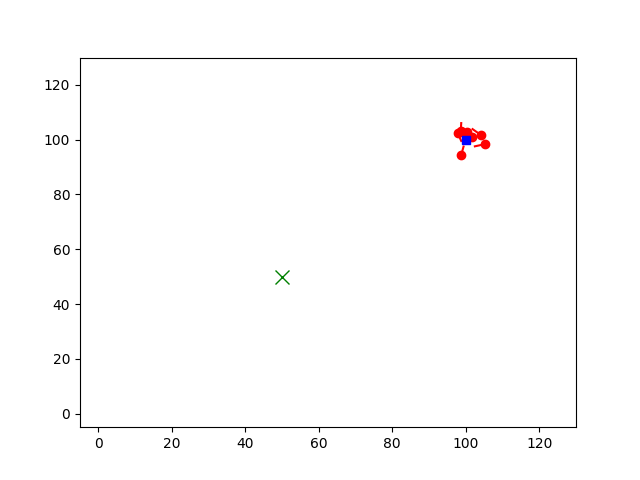

In [35]:
# plot figures
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

world_size = dview.pull('bf.size()', block=True, targets=0)
fig_frames = dview.pull('fig_frames', block=True, targets=0)
tail_length = dview.pull('tail_length', block=True, targets=0)
w_target = dview.pull('w_target', block=True, targets=0)
danger_position = dview.pull('danger_position', block=True, targets=0)

for i in range(0,fig_frames):
    ax.clear()
    
    X_current_across_network = np.zeros((2, world_size))
    V_current_across_network = np.zeros((2, world_size))
    
    for k in range(world_size):
        X_current_across_network[:,[k]] = dview.pull('x_record[:, [{}]]'.format(i), block=True, targets=k)
        V_current_across_network[:,[k]] = dview.pull('v_record[:, [{}]]'.format(i), block=True, targets=k)
    
    ax.plot(X_current_across_network[0,:], X_current_across_network[1,:], 'ro')

    for k in range(world_size):
        vx, vy = V_current_across_network[0,k], V_current_across_network[1,k]
        x, y = X_current_across_network[0,k], X_current_across_network[1,k]
        ax.plot([x-tail_length*vx,x], [y-tail_length*vy, y], 'r-')

    ax.plot(w_target[0], w_target[1], 'bs')
    ax.plot(danger_position[0,0], danger_position[1,0], 'gx', markersize=10)
    ax.axis([-5, 130, -5, 130])
    fig.canvas.draw()
    plt.pause(0.1)

## 3. Multiple fishes escape from a chasing predator

In this section, we will simulate the scenario where a bunch of fishes will escape from the chase of a moving predator. Compared to the multiple fishes scenario with a static predator, there is only one major difference:

- the predator is moving.

The predator may have different strategies to chase the fish schools. It can chase the nearest fish, or it can chase  the center of the fish schools. In this section, we assume the predator takes the second strategy.

Moreover, when the predator is very close, we assume the fish will speed up to escape from it.

In [50]:
%%px

# local velocity
def local_velocity_moving_predator(target_position, current_position, danger_position, danger_range):
    
    target_position = target_position.reshape(-1,1)
    current_position = current_position.reshape(-1,1)
    danger_position = danger_position.reshape(-1,1)
    
    vl =  (target_position - current_position)/torch.norm(target_position - current_position)
    
    distance_to_danger = torch.norm(current_position - danger_position)
    
    # 1. safe range: go to food source normally
    if distance_to_danger > 2 * danger_range:
        return vl, 1
    
    # 2. slightly dangerous range, and the predator is chasing from behind
    if distance_to_danger > danger_range \
        and distance_to_danger < 2 * danger_range \
        and (current_position - danger_position).T@vl > 0:
        return vl, 1
    
    # 3. slightly dangerous range, and the predator is chasing from front
    if distance_to_danger > danger_range \
        and distance_to_danger < 2 * danger_range \
        and (current_position - danger_position).T@vl < 0:
        
        escape_direction = current_position - danger_position
        
        # escapte in the perpendicular direction
        vl_new = torch.tensor([escape_direction[1], -escape_direction[0]]).reshape(-1,1)
        if vl_new.T@vl > 0:
            return vl_new/torch.norm(vl_new), 1
        else:
            return -vl_new/torch.norm(vl_new), 1
        
    # 4. very dangerous range. Has to speedup to run away
    if distance_to_danger < danger_range:
        v_runaway = (current_position - danger_position)/torch.norm(current_position - danger_position)
        return v_runaway, 2*danger_range/distance_to_danger - 1

In [51]:
%%px

def multiple_fish_move_across_moving_predator_one_step(ith):
    
    global w_target, x, w, v_record, x_record, vl, vg, beta
    
    # get measurements u and d
    u = getU(target_position=w_target, current_position=x, noise=0.5).reshape(-1,1)
    d = getD(u=u, target_position=w_target, current_position=x, noise=0.5)
    
    # find neighbors
    self_weight, neighbor_weights = find_neighbors_allgather(x, r1)
    
    # estimate target position via diffusion
    w = diffusion_one_recursion(x, u, d, w, gamma, self_weight, neighbor_weights)
    # get local velocity
    vl, v_scale = local_velocity_moving_predator(w_target, x, danger_position, danger_range)
    # get group velocity
    vg = group_velocity(vl, vg, self_weight, neighbor_weights, beta)
    # get collistion velocity
    vc = avoid_collision_velocity(x, r1, r2)
    # get final velocity
    v  = lmd * vl + (1-lmd) * (vg + vc)
    v  = v / torch.norm(v)
    # the fish speed up to escape from the predator
    if v_scale > 1:
        v *= 1.2
    
    # update current location
    x = x + delta_t*v
    
    # record data
    v_record[:, [ith]] = v
    x_record[:,[ith]] = x
    
    return bf.allreduce(x, name = 'x_mean')   

In [63]:
%%px

delta_t = 3      # time interval
fig_frames = 50  # figures frames
tail_length = 3  # the length of tail
gamma = 0.5      # for estimation
beta  = 0.5      # for group velocity
r1    = 100      # to determine neighbors
r2    = 10       # to keep save distance
lmd   = 0.8      # to balance velocities

# target
w_target = torch.tensor([100,100]).reshape(-1,1)

# predator
danger_position = torch.tensor([50,50]).reshape(-1,1)
danger_range    = 10

# position
X = torch.zeros((2,fig_frames))
x_init = torch.rand(2,1) * 3 + 20
w_init = torch.rand(2,1)

# start simulation
v_record = torch.zeros((2, fig_frames))
x_record = torch.zeros((2, fig_frames))
x = x_init.clone()
w = w_init.clone()
vg = torch.rand(2,1)

In [64]:
# predator position
danger_position = torch.tensor([50,50]).reshape(-1,1)

In [65]:
# simulation starts
pv_record = torch.zeros((2, fig_frames))
px_record = torch.zeros((2, fig_frames))

fig_frames = dview.pull('fig_frames', block=True, targets=0)
delta_t = dview.pull('delta_t', block=True, targets=0)
for i in range(0, fig_frames):
    if i % 10 == 0:
        print('progress: {}/{}'.format(i, fig_frames))
    dview.push({"ith": i}, block=True)
    dview.push({"danger_position": danger_position}, block=True)
    %px x_mean = multiple_fish_move_across_moving_predator_one_step(ith)
    
    # predator chases the fish school center
    x_mean = dview.pull('x_mean', block=True, targets=0)
    vp = (x_mean - danger_position)/torch.norm(x_mean - danger_position)
    danger_position = danger_position + delta_t * vp
    
    # record p data
    pv_record[:, [i]] = vp
    px_record[:,[i]] = danger_position

progress: 0/50
progress: 10/50
progress: 20/50
progress: 30/50
progress: 40/50


<IPython.core.display.Javascript object>


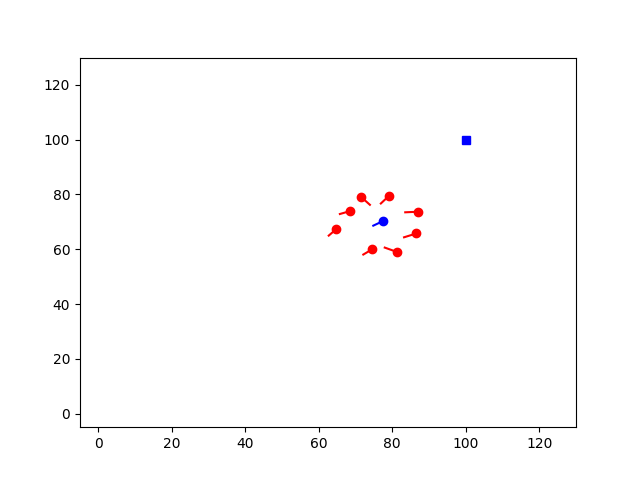

In [66]:
# plot figures
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

world_size = dview.pull('bf.size()', block=True, targets=0)
fig_frames = dview.pull('fig_frames', block=True, targets=0)
tail_length = dview.pull('tail_length', block=True, targets=0)
w_target = dview.pull('w_target', block=True, targets=0)
danger_position = dview.pull('danger_position', block=True, targets=0)

for i in range(0,fig_frames):
    ax.clear()
    
    X_current_across_network = np.zeros((2, world_size))
    V_current_across_network = np.zeros((2, world_size))
    
    for k in range(world_size):
        X_current_across_network[:,[k]] = dview.pull('x_record[:, [{}]]'.format(i), block=True, targets=k)
        V_current_across_network[:,[k]] = dview.pull('v_record[:, [{}]]'.format(i), block=True, targets=k)
    
    ax.plot(X_current_across_network[0,:], X_current_across_network[1,:], 'ro')

    for k in range(world_size):
        vx, vy = V_current_across_network[0,k], V_current_across_network[1,k]
        x, y = X_current_across_network[0,k], X_current_across_network[1,k]
        ax.plot([x-tail_length*vx,x], [y-tail_length*vy, y], 'r-')

    ax.plot(w_target[0], w_target[1], 'bs')
    
    px, py = px_record[0,i], px_record[1,i]
    pvx, pvy = pv_record[0,i], pv_record[1,i]
    ax.plot(px, py, 'bo')
    ax.plot([px-tail_length*pvx,px], [py-tail_length*pvy, py], 'b-')
    
    ax.axis([-5, 130, -5, 130])
    fig.canvas.draw()
    plt.pause(0.1)